In [100]:
import numpy as np
from matplotlib import pyplot as plt
from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay, ArrayDisplay
from ctapipe.reco import HillasReconstructor
from ctapipe.image import hillas_parameters, tailcuts_clean, timing_parameters
from ctapipe.image import brightest_island, number_of_islands
import math
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz
from ctapipe.coordinates import CameraFrame
from ctapipe.coordinates.utils import altaz_to_righthanded_cartesian


In [3]:
dl1_file = "gamma-diffuse_with_images_00.dl2.h5"

source = EventSource(
    input_url = dl1_file,
    max_events = None
)
subarray = source.subarray

Table /configuration/simulation/run is missing column None for field run_number of container <class 'ctapipe.containers.SimulationConfigContainer'>. It will be skipped.


#### Mono Reco for all events on tel id 10

In [4]:
TEL_ID = 10 
mono_events = []

for event in source:

    if TEL_ID not in event.dl1.tel:
        continue

    dl1 = event.dl1.tel[TEL_ID]

    if dl1.image is None:
        continue

    mono_events.append(event)

print(f"Number of mono events for telescope {TEL_ID}: {len(mono_events)}")

Table /dl1/event/telescope/trigger is missing column event_type for field event_type of container <class 'ctapipe.containers.TelescopeTriggerContainer'>. It will be skipped.
Table /simulation/event/subarray/shower is missing column true_starting_grammage for field starting_grammage of container <class 'ctapipe.containers.SimulatedShowerContainer'>. It will be skipped.
Table /dl2/event/subarray/geometry/HillasReconstructor is missing column HillasReconstructor_ang_distance_uncert for field ang_distance_uncert of container <class 'ctapipe.containers.ReconstructedGeometryContainer'>. It will be skipped.
Table /dl1/event/telescope/parameters/tel_035 is missing column hillas_psi_uncertainty for field psi_uncertainty of container <class 'ctapipe.containers.HillasParametersContainer'>. It will be skipped.
Table /dl1/event/telescope/parameters/tel_035 is missing column hillas_transverse_cog_uncertainty for field transverse_cog_uncertainty of container <class 'ctapipe.containers.HillasParameter

Number of mono events for telescope 10: 7570


In [5]:
print(f"Number of mono events for telescope {TEL_ID}: {len(mono_events)}")

Number of mono events for telescope 10: 7570


In [6]:
mono_events[0].dl1.tel[TEL_ID].image

array([ 1.2, -1.3, -1.1, ...,  0.4, -0.6,  2.7], dtype=float32)

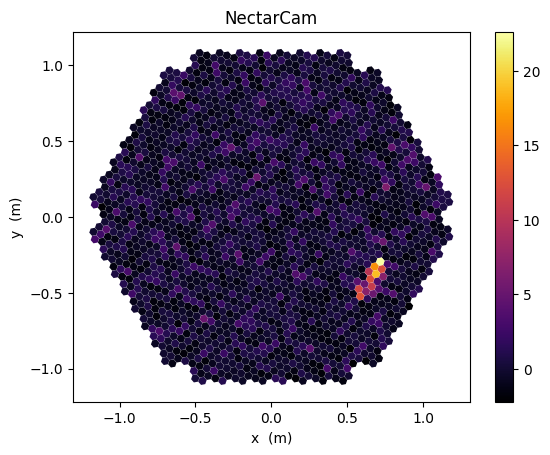

In [86]:
event = mono_events[5] # 9 is another good number
image = event.dl1.tel[TEL_ID].image
geometry = subarray.tel[TEL_ID].camera.geometry
disp = CameraDisplay( 
        geometry,
        image=image,
        show_frame=False
    )
disp.add_colorbar()

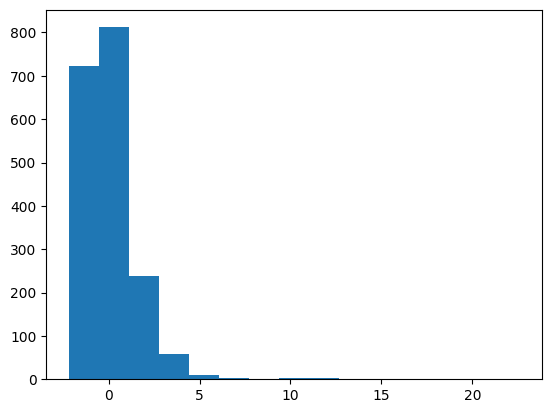

In [87]:
plt.hist(image, bins=15);

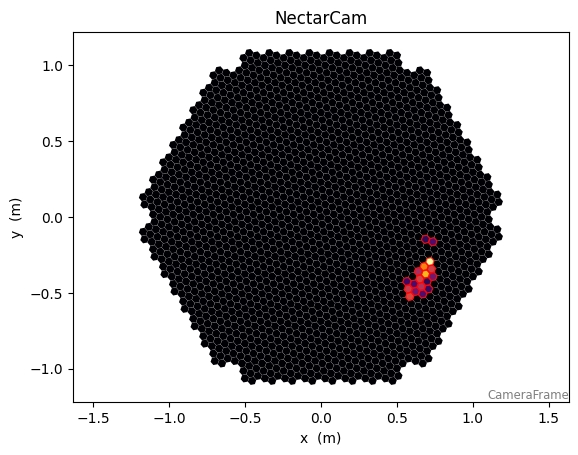

In [88]:
pt = 5
bt = 3
clean_mask = tailcuts_clean(geometry, image, picture_thresh = pt, boundary_thresh =bt)
clean_image = image.copy()
clean_image[~clean_mask] = 0.0

disp = CameraDisplay(geometry, image=clean_image)
disp.highlight_pixels(clean_mask, color="red")

In [89]:
n_islands, island_labels = number_of_islands(geometry, clean_mask)
brightest_island_mask = brightest_island(n_islands, island_labels, clean_image)
n_islands

2

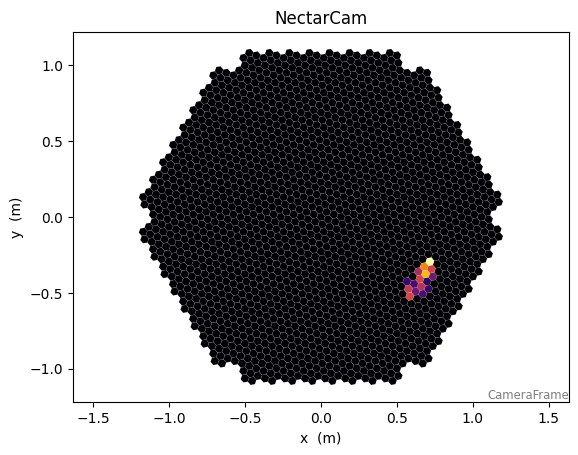

In [90]:
clean_image[~brightest_island_mask] = 0
disp = CameraDisplay(geometry, image=clean_image)
#disp.highlight_pixels(brightest_island_mask, color="red")

In [91]:
hillas = hillas_parameters(geometry, clean_image)
print(hillas)

{'intensity': np.float64(164.39999866485596),
 'kurtosis': np.float64(1.8669790945374383),
 'length': <Quantity 0.08270887 m>,
 'length_uncertainty': <Quantity 0.00300314 m>,
 'phi': <Angle -0.54085277 rad>,
 'psi': <Angle 1.01966658 rad>,
 'psi_uncertainty': <Angle 0.06209665 rad>,
 'r': <Quantity 0.77613386 m>,
 'skewness': np.float64(-0.24910368155504437),
 'transverse_cog_uncertainty': <Quantity 0.0035564 m>,
 'width': <Quantity 0.03095247 m>,
 'width_uncertainty': <Quantity 0.00172689 m>,
 'x': <Quantity 0.66535622 m>,
 'y': <Quantity -0.39960589 m>}


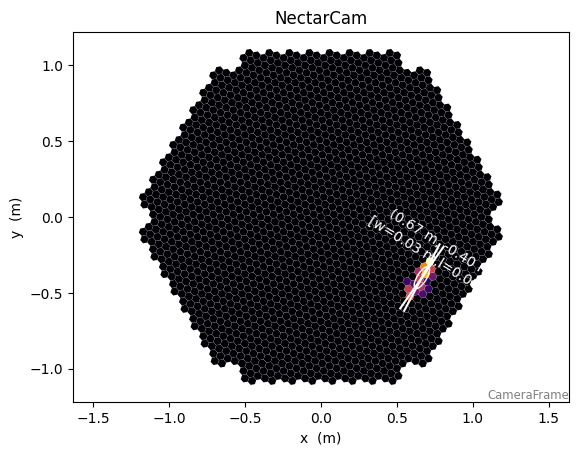

In [99]:
clean_image[~brightest_island_mask] = 0
disp = CameraDisplay(geometry, image=clean_image)
disp.overlay_moments(hillas, color="white")

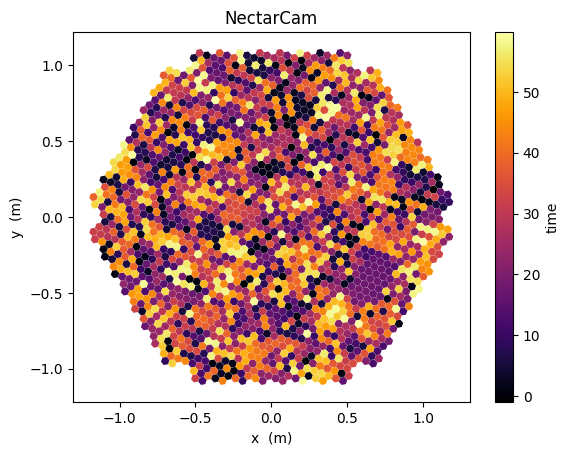

In [97]:
time = event.dl1.tel[TEL_ID].peak_time
disp = CameraDisplay( 
        geometry,
        image=time,
        show_frame=False
    )
disp.add_colorbar(label="time")

In [101]:
timing = timing_parameters(geometry, image, time, hillas, clean_image)

In [104]:
print(timing)

{'deviation': 8.313505840827666,
 'intercept': np.float64(17.316734427120185),
 'slope': <Quantity -8.12199797 1 / m>}


In [111]:
mono_events
hillas_list = []
timings = []
for event in mono_events[:1000]:
    image = event.dl1.tel[TEL_ID].image
    geometry = subarray.tel[TEL_ID].camera.geometry
    pt, bt = 5, 3
    clean_mask = tailcuts_clean(geometry, image, picture_thresh = pt , boundary_thresh = bt)
    clean_image = image.copy()
    n_islands, island_labels = number_of_islands(geometry, clean_mask)
    brightest_island_mask = brightest_island(n_islands, island_labels, clean_image)
    clean_image[~brightest_island_mask] = 0
    hillas = hillas_parameters(geometry, clean_image)
    hillas_list.append(hillas)
    timing = timing_parameters(geometry, image, time, hillas, brightest_island_mask)
    timings.append(timing)

In [112]:
event.simulation["shower"].energy

<Quantity 2.20933437 TeV>

In [120]:
energies = []
intensity = []
tpars = []
for hillas, ev, timing in zip(hillas_list, mono_events, timings):
    energies.append(ev.simulation["shower"].energy.to("TeV").value)
    intensity.append(hillas["intensity"])
    tpars.append(timing["slope"].value)

Text(0, 0.5, 'intensity')

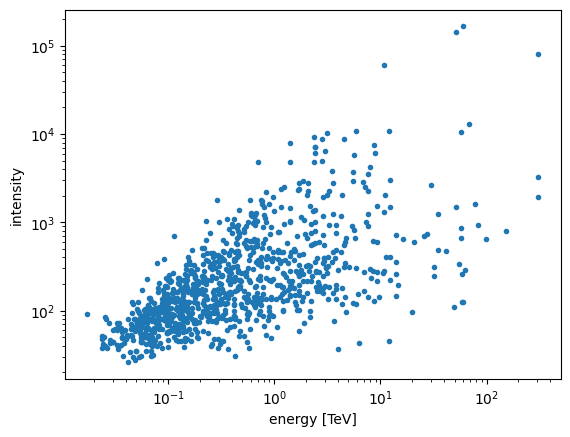

In [121]:
plt.plot(energies, intensity, ".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("energy [TeV]")
plt.ylabel("intensity")

Text(0, 0.5, 'intensity')

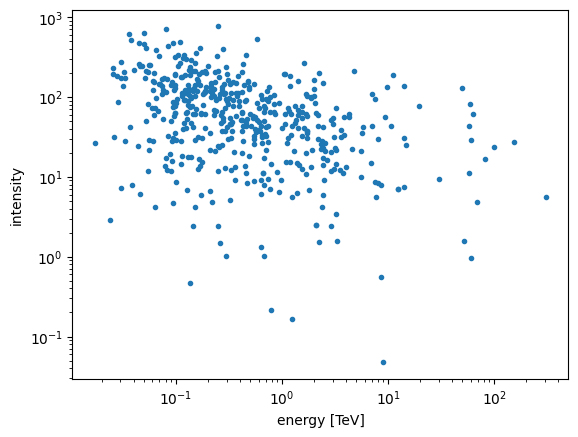

In [124]:
plt.plot(energies, tpars, ".")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("energy [TeV]")
plt.ylabel("intensity")